# Wind Turbine Power Generation Forecasting

Train dataset contains hourly meteorological data along with power output measurements collected between January 2013 and December 2016. The data includes variables such as temperature, relative humidity, wind speed at various altitudes, and power generated at different locations.

## Prepare workspace

1. Import dependencies.

In [1]:
import numpy as np
import pandas as pd
import sklearn

from lib.ml.layer.layer_def import Dense, Input
from lib.ml.util.loss_function import MEAN_SQUARED_ERROR
from lib.ml.model.seq_model import SeqNet, ValidationData
from lib.ml.optimizer.genetic_optimizer import GeneticOptimizer
from lib.ml.optimizer.gradient_descent_optimizer import GradientDescentOptimizer
from lib.ml.util.progress_tracker import NotebookProgressTracker

from lib.ml.util.activation_function import RELU_ACTIVATION
from src.data.wind_turbine.wind_turbine_dataset import (
    download_wind_turbine_dataset,
    process_wind_turbine_dataset,
    window_and_split,
)
from src.definitions import EXTERNAL_DATA_FOLDER
from src.visualization.plot import plot_loss_and_val_loss, plot_diff

from sklearn.discriminant_analysis import StandardScaler

2. Download and process `sudhanvahg/wind-turbine-power-generation-forecasting` dataset.

In [2]:
archive = download_wind_turbine_dataset(EXTERNAL_DATA_FOLDER)

3. Split on train/test/validate. Extract free and bound variables. Scale input.

In [3]:
scaler = StandardScaler()

dataset = process_wind_turbine_dataset(
    archive,
    scaler=scaler,
)

dataset.head(5)

,Temp_2m,RelHum_2m,DP_2m,WS_10m,WS_100m,WD_10m,WD_100m,WG_10m,Power,Location_1,Location_2,Location_3,Location_4
0,-0.804021,0.837857,-0.562194,-1.355386,-1.850563,-0.555885,-0.391588,-1.845008,-0.586907,1.0,0.0,0.0,0.0
1,-0.808581,0.896680,-0.552661,-1.049536,-0.957421,-0.505925,-0.431150,-1.017793,-0.670053,1.0,0.0,0.0,0.0
2,-0.881539,1.190795,-0.562194,-1.424449,-1.353283,-0.535901,-0.510276,-1.348679,-0.752804,1.0,0.0,0.0,0.0
3,-0.854179,1.014326,-0.571727,-1.424449,-1.382727,-1.435186,-0.955355,-1.789861,-0.835949,1.0,0.0,0.0,0.0
4,-0.858739,1.014326,-0.581260,-0.847281,-0.813472,-1.435186,-1.163059,-1.128089,-0.918700,1.0,0.0,0.0,0.0


In [4]:
x_train, y_train, x_valid, y_valid, x_test, y_test = window_and_split(
    dataset=dataset, test_train_ratio=0.8, train_valid_ratio=0.9, window_size=10
)

print("x_train = " + str(x_train.shape))
print("y_train = " + str(y_train.shape))
print("x_valid = " + str(x_valid.shape))
print("y_valid = " + str(y_valid.shape))
print("x_test = " + str(x_test.shape))
print("y_test = " + str(y_test.shape))

validation_data = ValidationData(x_valid, y_valid)

x_train = (130, 100886)
y_train = (1, 100886)
x_valid = (130, 11210)
y_valid = (1, 11210)
x_test = (130, 28024)
y_test = (1, 28024)


## Train NN using genetic optimizer

1. Define neural network.

In [5]:
model = SeqNet(
    layers=[
        Input(x_train.shape[0]),
        Dense(64, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

opt = GeneticOptimizer(
    population_size=200, mutation_rate=0.5, mutation_decay=0.005
)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

loss = 0.5082708246973007


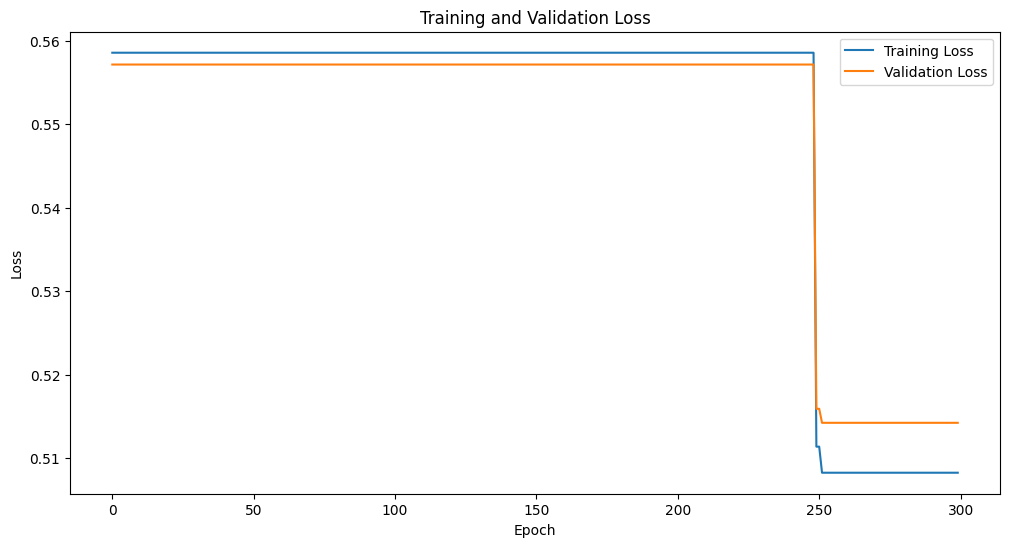

In [6]:
trained_model = compiled_model.fit(
    x_train, y_train, 300, validation_data=validation_data
)

print("loss = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

loss = 0.5139303805427811
R2 score = 0.48920681481919215


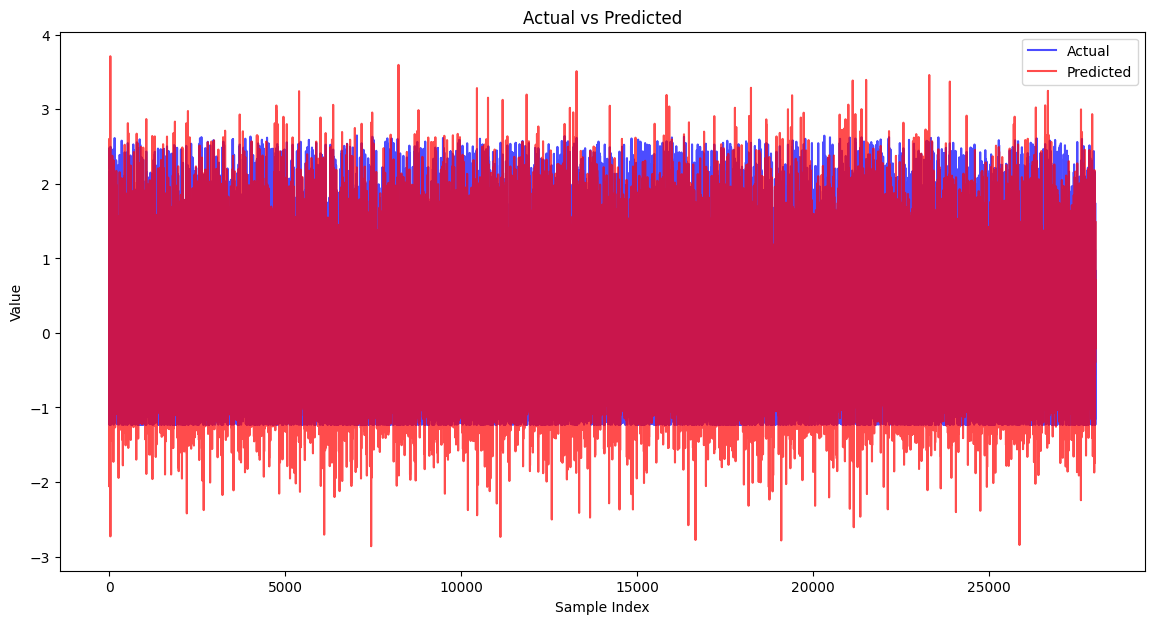

In [7]:
y_predicted = trained_model.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Build report

In [8]:
delta = y_test - y_predicted

report = pd.DataFrame(
    {
        "Power RO": y_test.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,2.212837,0.944457,1.268380,1.608788
1,2.478034,2.602498,-0.124464,0.015491
2,0.932560,-0.210154,1.142714,1.305795
3,-0.384758,-2.057520,1.672762,2.798132
4,-0.447807,0.541913,-0.989720,0.979546
5,-0.644833,0.038508,-0.683342,0.466956
6,-1.046767,-0.398611,-0.648155,0.420106
7,-0.216498,0.186761,-0.403259,0.162618
8,-0.484060,-0.122083,-0.361976,0.131027
9,-1.231184,-1.171788,-0.059396,0.003528


Delta total = 2.186345904697009
Delta^2 total = 9.682026066022972


## Train NN using gradient descent optimizer

1. Define Neural network

In [25]:
model = SeqNet(
    layers=[
        Input(x_train.shape[0]),
        Dense(128, activation_fun=RELU_ACTIVATION),
        Dense(64, activation_fun=RELU_ACTIVATION),
        Dense(64, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

opt = GradientDescentOptimizer(learning_rate=1e-3, momentum_decay=0.9)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Train accuracy = 0.811042436239295


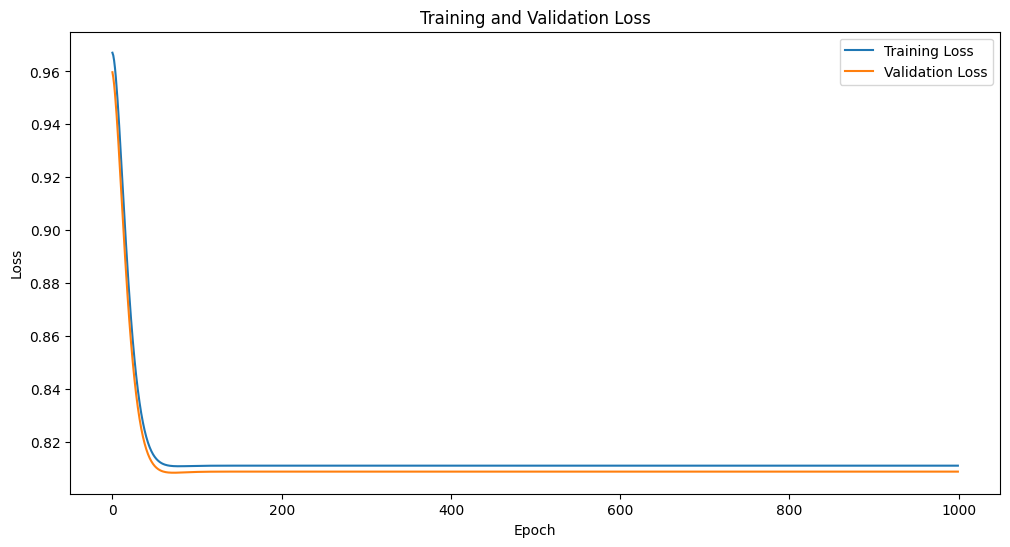

In [26]:
trained_model = compiled_model.fit(
    x_train, y_train, 1000, validation_data=validation_data
)

print("Train accuracy = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

loss = 0.8107144357574615
R2 score = 0.19423442436841176


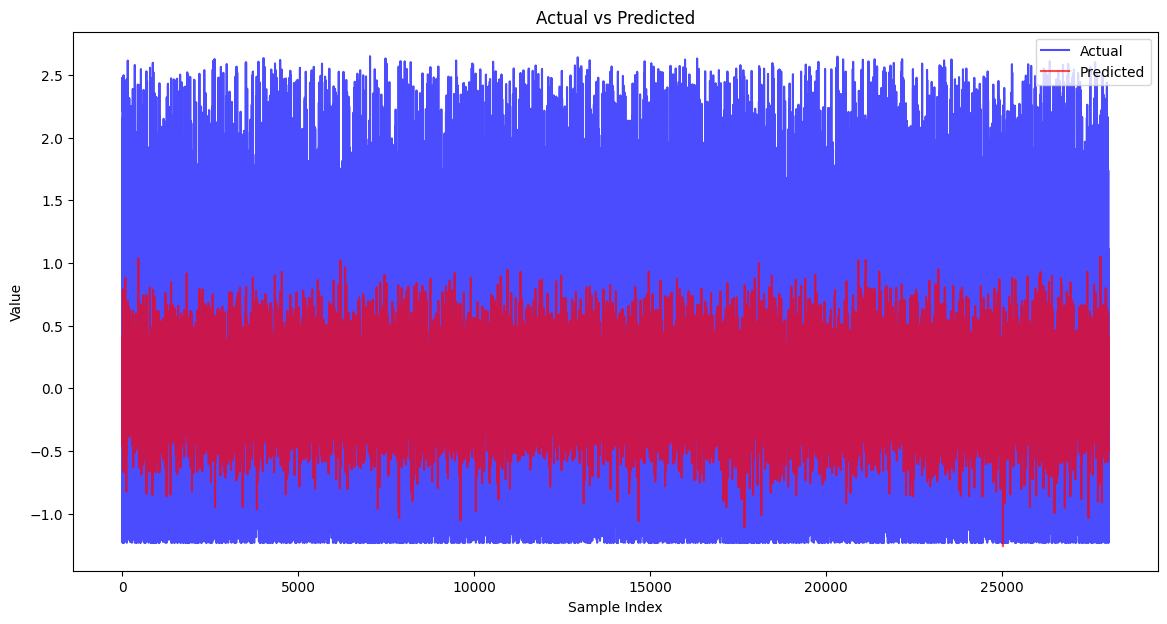

In [27]:
y_predicted = trained_model.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Build report

In [28]:
delta = y_test - y_predicted

report = pd.DataFrame(
    {
        "Power RO": y_test.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,2.212837,0.420562,1.792275,3.212250
1,2.478034,-0.029192,2.507226,6.286181
2,0.932560,0.207500,0.725059,0.525711
3,-0.384758,-0.100556,-0.284202,0.080771
4,-0.447807,-0.129822,-0.317984,0.101114
5,-0.644833,0.242601,-0.887434,0.787540
6,-1.046767,-0.459500,-0.587267,0.344883
7,-0.216498,-0.456527,0.240029,0.057614
8,-0.484060,0.276970,-0.761030,0.579167
9,-1.231184,-0.331155,-0.900028,0.810051


Delta total = 2.406172784956916
Delta^2 total = 14.056762032225727
